# Big Data Project - Recommender Systems
## Mohamad Abdallah & Mohamad-Kazem Al-Seblani
### May 2021

## Instructions
We would like to implement and compare recommender systems for a video streaming company like Netflix based on the ratings of the viewers. We will assume a star rating system where users express their satisfaction by ticking the corresponding number of stars (between 0 and 5)

We would like to implement and compare the following recommender systems:
1. Item to item collaborative filtering 
2. User to User collaborative filtering
3. Global Baseline
4. Principal component analysis (PCA using SVD)


The SVD computation is of no interest, consider using a library in your language of choice


<p><b>Data:</b></p>
* Unique movies: 4,156.<br>
* Unique users: 363,086.<br>
* Total ratings: 2,000,000.<br>
* Ratings are on a five star (integral) scale from 1 to 5.


<b>Dataset:</b><br>

1. movie_titles.csv (MovieID, CustID, Ratings, Date)

  
dataset: MovieLens 100K Dataset.<br>
dataset source: https://grouplens.org/datasets/movielens/100k/

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error


import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

## 1. Reading and Storing Data

In [2]:
# creating data frame from our output csv file.
#if not os.path.isfile("../Data/NetflixData.pkl"):
startTime = datetime.now()
Final_Data = pd.read_csv("../Data/NetflixRatings_2M.csv", sep=",", names = ["MovieID","CustID", "Ratings", "Date"])
Final_Data["Date"] = pd.to_datetime(Final_Data["Date"])
Final_Data.sort_values(by = "Date", inplace = True)
print("Time taken for execution of above code = "+str(datetime.now() - startTime))

Time taken for execution of above code = 0:00:02.335315


In [3]:
# storing pandas dataframe as a picklefile for later use
# Python pickle module is used for serializing and de-serializing a Python object structure. 
# Any object in Python can be pickled so that it can be saved on disk
if not os.path.isfile("../Data/NetflixData.pkl"):
    Final_Data.to_pickle("../Data/NetflixData.pkl")
else:
    Final_Data = pd.read_pickle("../Data/NetflixData.pkl")

In [6]:
#Final_Data.reset_index(drop=True, inplace=True)
Final_Data.head()

,MovieID,CustID,Ratings,Date
0,10774,510180,3,1999-11-11
1,12926,510180,2,1999-12-12
2,12309,510180,3,1999-12-16
3,10832,1972971,4,1999-12-16
4,11859,731941,3,1999-12-17


In [7]:
Final_Data.describe()["Ratings"]

count    2.000000e+06
mean     3.605929e+00
std      1.089970e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Ratings, dtype: float64

### Checking for NaN

In [8]:
print("Number of NaN values = "+str(Final_Data.isnull().sum()))

Number of NaN values = MovieID    0
CustID     0
Ratings    0
Date       0
dtype: int64


### Removing Duplicates

In [9]:
duplicates = Final_Data.duplicated(["MovieID","CustID", "Ratings"])
print("Number of duplicate rows = "+str(duplicates.sum()))

Number of duplicate rows = 0


### Basic Statistics

In [10]:
print("Total number of movie ratings = "+str(Final_Data.shape[0]))
print("Number of unique users = "+str(len(np.unique(Final_Data["CustID"]))))
print("Number of unique movies = "+str(len(np.unique(Final_Data["MovieID"]))))

Total number of movie ratings = 2000000
Number of unique users = 363086
Number of unique movies = 4156


### Splitting  data into Train and Test(80:20)

In [11]:
if not os.path.isfile("../Data/TrainData.pkl"):
    Final_Data.iloc[:int(Final_Data.shape[0]*0.80)].to_pickle("../Data/TrainData.pkl")
    Train_Data = pd.read_pickle("../Data/TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)
else:
    Train_Data = pd.read_pickle("../Data/TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)

if not os.path.isfile("../Data/TestData.pkl"):
    Final_Data.iloc[int(Final_Data.shape[0]*0.80):].to_pickle("../Data/TestData.pkl")
    Test_Data = pd.read_pickle("../Data/TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)
else:
    Test_Data = pd.read_pickle("../Data/TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)

### Basic Statistics in Train data

In [12]:
Train_Data.head()

,MovieID,CustID,Ratings,Date
0,10774,510180,3,1999-11-11
1,12926,510180,2,1999-12-12
2,12309,510180,3,1999-12-16
3,10832,1972971,4,1999-12-16
4,11859,731941,3,1999-12-17


### Basic Statistics in Test data

In [13]:
Test_Data.head()

,MovieID,CustID,Ratings,Date
0,10550,610814,3,2005-08-12
1,11265,2198694,3,2005-08-12
2,12870,217199,5,2005-08-12
3,10561,1238756,4,2005-08-12
4,12833,995935,4,2005-08-12


In [14]:
print("Total Test Data:")
print("Total number of movie ratings in Test data = "+str(Test_Data.shape[0]))
print("Number of unique users in Test data = "+str(len(np.unique(Test_Data["CustID"]))))
print("Number of unique movies in Test data = "+str(len(np.unique(Test_Data["MovieID"]))))
print("Highest value of a User ID = "+str(max(Test_Data["CustID"].values)))
print("Highest value of a Movie ID = "+str(max(Test_Data["MovieID"].values)))

Total Test Data:
Total number of movie ratings in Test data = 400000
Number of unique users in Test data = 153687
Number of unique movies in Test data = 3861
Highest value of a User ID = 2649429
Highest value of a Movie ID = 13366


## 2. Creating USER-ITEM sparse matrix from data frame

In [15]:
print("Total Train Data:")
print("Total number of movie ratings in train data = "+str(Train_Data.shape[0]))
print("Number of unique users in train data = "+str(len(np.unique(Train_Data["CustID"]))))
print("Number of unique movies in train data = "+str(len(np.unique(Train_Data["MovieID"]))))
print("Highest value of a User ID = "+str(max(Train_Data["CustID"].values)))
print("Highest value of a Movie ID = "+str(max(Train_Data["MovieID"].values)))

Total Train Data:
Total number of movie ratings in train data = 1600000
Number of unique users in train data = 295834
Number of unique movies in train data = 4028
Highest value of a User ID = 2649429
Highest value of a Movie ID = 13367


In [16]:
startTime = datetime.now()
print("Creating USER_ITEM sparse matrix for train Data")
if os.path.isfile("../Data/TrainUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TrainUISparseData = sparse.load_npz("../Data/TrainUISparseData.npz")
    print("Shape of Train Sparse matrix = "+str(TrainUISparseData.shape))
    
else:
    print("We are creating sparse data")
    TrainUISparseData = sparse.csr_matrix((Train_Data.Ratings, (Train_Data.CustID, Train_Data.MovieID)))
    print("Creation done. Shape of sparse matrix = "+str(TrainUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz("../Data/TrainUISparseData.npz", TrainUISparseData)
    print("Done\n")

print(datetime.now() - startTime)

Creating USER_ITEM sparse matrix for train Data
We are creating sparse data
Creation done. Shape of sparse matrix = (2649430, 13368)
Saving it into disk for furthur usage.
Done

0:00:01.836180


In [17]:
startTime = datetime.now()
print("Creating USER_ITEM sparse matrix for test Data")
if os.path.isfile("../Data/TestUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TestUISparseData = sparse.load_npz("../Data/TestUISparseData.npz")
    print("Shape of Test Sparse Matrix = "+str(TestUISparseData.shape))
else:
    print("We are creating sparse data")
    TestUISparseData = sparse.csr_matrix((Test_Data.Ratings, (Test_Data.CustID, Test_Data.MovieID)))
    print("Creation done. Shape of sparse matrix = "+str(TestUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz("../Data/TestUISparseData.npz", TestUISparseData)
    print("Done\n")

print(datetime.now() - startTime)

Creating USER_ITEM sparse matrix for test Data
We are creating sparse data
Creation done. Shape of sparse matrix = (2649430, 13367)
Saving it into disk for furthur usage.
Done

0:00:00.575947


In [18]:
#Shape of sparse matrix depends on highest value of User ID and highest value of Movie ID. 
#Now the user whose user ID is highest is present in both train data and test data. Similarly, the movie whose movie ID is
#highest is present in both train data and test data. Hence, shape of both train and test sparse matrices are same.

In [19]:
rows,cols = TrainUISparseData.shape
presentElements = TrainUISparseData.count_nonzero()

print("Sparsity Of Train matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Train matrix : 99.99548246947093% 


In [20]:
rows,cols = TestUISparseData.shape
presentElements = TestUISparseData.count_nonzero()

print("Sparsity Of Test matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Test matrix : 99.99887053287738% 


### Finding Global average of all movie ratings, Average rating per user, and Average rating per movie

In [21]:
def getAverageRatings(sparseMatrix, if_user):
    ax = 1 if if_user else 0
    #axis = 1 means rows and axis = 0 means columns 
    sumOfRatings = sparseMatrix.sum(axis = ax).A1  #this will give an array of sum of all the ratings of user if axis = 1 else 
    #sum of all the ratings of movies if axis = 0
    noOfRatings = (sparseMatrix!=0).sum(axis = ax).A1  #this will give a boolean True or False array, and True means 1 and False 
    #means 0, and further we are summing it to get the count of all the non-zero cells means length of non-zero cells
    rows, cols = sparseMatrix.shape
    averageRatings = {i: sumOfRatings[i]/noOfRatings[i] for i in range(rows if if_user else cols) if noOfRatings[i]!=0}
    return averageRatings

### Global Average Rating

In [22]:
Global_Average_Rating = TrainUISparseData.sum()/TrainUISparseData.count_nonzero()
print("Global Average Rating {}".format(Global_Average_Rating))

Global Average Rating 3.58526875


### Average Rating Per User

In [23]:
AvgRatingUser = getAverageRatings(TrainUISparseData, True)

In [24]:
print("Average rating of user 1277134 = {}".format(AvgRatingUser[1277134]))

Average rating of user 1277134 = 3.2222222222222223


### Average Rating Per Movie

In [25]:
AvgRatingMovie = getAverageRatings(TrainUISparseData, False)

In [26]:
print("Average rating of movie 9211 = {}".format(AvgRatingMovie[9211]))

Average rating of movie 9211 = 2.3541666666666665


## 3. Computing Similarity Matrices

### Computing User-User Similarity Matrix

In [27]:
row_index, col_index = TrainUISparseData.nonzero()
rows = np.unique(row_index)
for i in rows[:100]:
    print(i)

6
7
10
42
59
79
83
87
97
134
142
168
169
178
183
188
189
192
195
199
201
242
247
248
265
266
267
268
283
291
298
301
302
304
305
307
312
331
333
352
363
369
383
384
392
413
424
437
439
440
442
462
470
471
477
478
481
485
492
495
508
527
536
544
546
550
561
592
596
602
609
614
616
657
663
664
684
688
695
719
735
739
742
744
748
750
756
766
767
769
781
785
787
788
793
815
829
834
857
906


In [28]:
#Here, we are calculating user-user similarity matrix only for first 100 users in our sparse matrix. And we are calculating 
#top 100 most similar users with them.
def getUser_UserSimilarity(sparseMatrix, top = 100):
    startTimestamp20 = datetime.now()  
    
    row_index, col_index = sparseMatrix.nonzero()  #this will give indices of rows in "row_index" and indices of columns in 
    #"col_index" where there is a non-zero value exist.
    rows = np.unique(row_index)
    similarMatrix = np.zeros(90700).reshape(907,100)    # 907*100 = 290700. As we are building similarity matrix only 
    #for top 100 most similar users.
    timeTaken = []
    howManyDone = 0
    for row in rows[:top]:
        howManyDone += 1
        startTimestamp = datetime.now().timestamp()  #it will give seconds elapsed
        sim = cosine_similarity(sparseMatrix.getrow(row), sparseMatrix).ravel()
        top100_similar_indices = sim.argsort()[-top:]
        top100_similar = sim[top100_similar_indices]
        similarMatrix[row] = top100_similar
        timeforOne = datetime.now().timestamp() - startTimestamp
        timeTaken.append(timeforOne)
        if howManyDone % 20 == 0:
            print("Time elapsed for {} users = {}sec".format(howManyDone, (datetime.now() - startTimestamp20)))
    print("Average Time taken to compute similarity matrix for 1 user = "+str(sum(timeTaken)/len(timeTaken))+" seconds")
    
    fig = plt.figure(figsize = (12,8))
    plt.plot(timeTaken, label = 'Time Taken For Each User')
    plt.plot(np.cumsum(timeTaken), label='Cumulative Time')
    plt.legend(loc='upper left', fontsize = 15)
    plt.xlabel('Users', fontsize = 20)
    plt.ylabel('Time(Seconds)', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.show()
    
    return similarMatrix

Time elapsed for 20 users = 0:00:04.024741sec
Time elapsed for 40 users = 0:00:07.887276sec
Time elapsed for 60 users = 0:00:11.816932sec
Time elapsed for 80 users = 0:00:15.820362sec
Time elapsed for 100 users = 0:00:19.933427sec
Average Time taken to compute similarity matrix for 1 user = 0.1982944703102112 seconds


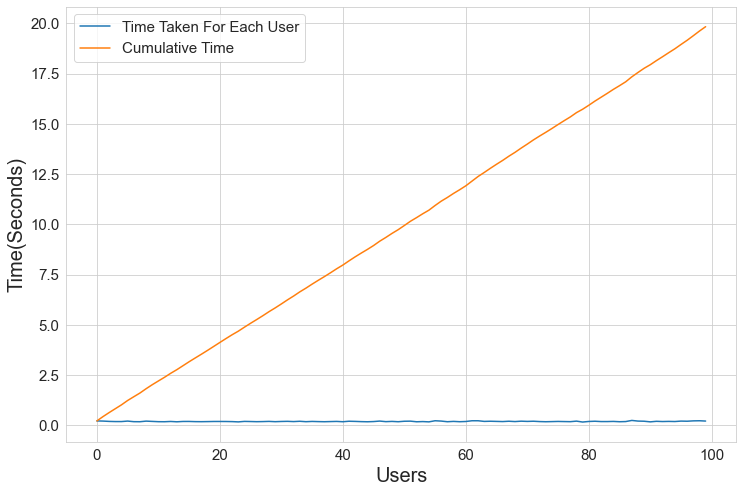

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.34585723, 0.34585723, 0.34585723, ..., 0.48420012, 0.48463911,
        1.        ]])

In [29]:
simMatrix = getUser_UserSimilarity(TrainUISparseData, 100)
simMatrix

<p>We have __<b>295834</b> Users__ in our training data.<br><br>Average time taken to compute similarity matrix for one user is __0.198 sec.__<br><br>For 295834 users:<br><br>295834*0.198 == 58,575 sec == 16.27 hours<br><br>so for the sake of the time:<br>We will Compute top (let's just say, 1000) most similar users for this given user, and add this to our datastructure, so that we can just access it(similar users) without recomputing it again.


### Computing Movie-Movie Similarity Matrix

In [50]:
start = datetime.now()

if not os.path.isfile("../Data/m_m_similarity.npz"):
    print("Movie-Movie Similarity file does not exist in your disk. Creating Movie-Movie Similarity Matrix...")
    
    m_m_similarity = cosine_similarity(TrainUISparseData.T, dense_output = False)
    print("Done")
    print("Dimension of Matrix = {}".format(m_m_similarity.shape))
    print("Storing the Movie Similarity matrix on disk for further usage")
    sparse.save_npz("../Data/m_m_similarity.npz", m_m_similarity)
else:
    print("File exists in the disk. Loading the file...")
    m_m_similarity = sparse.load_npz("../Data/m_m_similarity.npz")
    print("Dimension of Matrix = {}".format(m_m_similarity.shape))
    
print(datetime.now() - start)

File exists in the disk. Loading the file...
Dimension of Matrix = (13368, 13368)
0:00:00.308309


### Let's pick random movie and check it's top 10 most similar movies.

In [51]:
movie_ids = np.unique(m_m_similarity.nonzero())

In [52]:
similar_movies_dict = dict()
for movie in movie_ids:
    smlr = np.argsort(-m_m_similarity[movie].toarray().ravel())[1:100]
    similar_movies_dict[movie] = smlr

In [53]:
movie_titles_df = pd.read_csv("../Data/movie_titles.csv",sep = ",", header = None, names=['MovieID', 'Year_of_Release', 'Movie_Title'], index_col = "MovieID", encoding = "iso8859_2")

In [54]:
movie_titles_df.head()

,Year_of_Release,Movie_Title
MovieID,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


### Similar Movies to: __South Park: Season 2__

In [55]:
movieID_GR = 9236

print("Name of the movie -------> "+str(movie_titles_df.loc[movieID_GR][1]))

print("Number of ratings by users for movie {} is {}".format(movie_titles_df.loc[movieID_GR][1], TrainUISparseData[:,movieID_GR].getnnz()))

print("Number of similar movies to {} is {}".format(movie_titles_df.loc[movieID_GR][1], m_m_similarity[movieID_GR].count_nonzero()))

Name of the movie -------> South Park: Season 2
Number of ratings by users for movie South Park: Season 2 is 1038
Number of similar movies to South Park: Season 2 is 1873


In [56]:
# Meaning of "[:,9236]" means get all the values of column "9236".
# "getnnz()" give count of explicitly-stored values (nonzeros).

In [57]:
all_similar = sorted(m_m_similarity[movieID_GR].toarray().ravel(), reverse = True)[1:]

similar_100 = all_similar[:101]

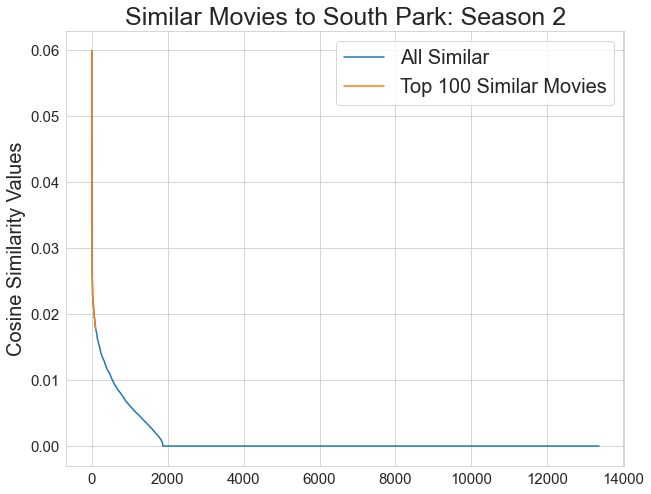

In [58]:
plt.figure(figsize = (10, 8))
plt.plot(all_similar, label = "All Similar")
plt.plot(similar_100, label = "Top 100 Similar Movies")
plt.title("Similar Movies to South Park: Season 2", fontsize = 25)
plt.ylabel("Cosine Similarity Values", fontsize = 20)
plt.tick_params(labelsize = 15)
plt.legend(fontsize = 20)
plt.show()

### Top 10 Similar Movies to: __South Park: Season 2__

In [59]:
movie_titles_df.loc[similar_movies_dict[movieID_GR][:10]]

,Year_of_Release,Movie_Title
MovieID,,
10418,1997.0,South Park: Season 1
11191,1999.0,South Park: Season 3
13267,2002.0,Gorillaz: Phase One Celebrity Take Down
9785,1996.0,Beavis and Butt-head Do America
12834,2001.0,Family Guy: Vol. 2: Season 3
11398,1980.0,Airplane!
9900,1994.0,Airheads
9628,1983.0,Star Wars: Episode VI: Return of the Jedi
10598,2004.0,Chappelle's Show: Season 2


<p>__It seems that Movie-Movie similarity is working perfectly.__</p>

## 4. Global Baseline

In [60]:
def get_sample_sparse_matrix(sparseMatrix, n_users, n_movies):
    startTime = datetime.now()
    users, movies, ratings = sparse.find(sparseMatrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)
    np.random.seed(15)   #this will give same random number everytime, without replacement
    userS = np.random.choice(uniq_users, n_users, replace = False)
    movieS = np.random.choice(uniq_movies, n_movies, replace = False)
    mask = np.logical_and(np.isin(users, userS), np.isin(movies, movieS))
    sparse_sample = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), 
                                                     shape = (max(userS)+1, max(movieS)+1))
    print("Sparse Matrix creation done. Saving it for later use.")
    sparse.save_npz(path, sparse_sample)
    print("Done")
    print("Shape of Sparse Sampled Matrix = "+str(sparse_sample.shape))
    
    print(datetime.now() - start)
    return sparse_sample

### Creating Sample Sparse Matrix for Train Data

In [61]:
path = "../Data/TrainUISparseData_Sample.npz"
if not os.path.isfile(path):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    train_sample_sparse = get_sample_sparse_matrix(TrainUISparseData, 4000, 400)
else:
    print("File is already present in the disk. Loading the file...")
    train_sample_sparse = sparse.load_npz(path)
    print("File loading done.")
    print("Shape of Train Sample Sparse Matrix = "+str(train_sample_sparse.shape))

Sample sparse matrix is not present in the disk. We are creating it...
Sparse Matrix creation done. Saving it for later use.
Done
Shape of Sparse Sampled Matrix = (2648244, 13362)
0:03:04.145617


### Creating Sample Sparse Matrix for Test Data

In [62]:
path = "../Data/TestUISparseData_Sample.npz"
if not os.path.isfile(path):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    test_sample_sparse = get_sample_sparse_matrix(TestUISparseData, 2000, 200)
else:
    print("File is already present in the disk. Loading the file...")
    test_sample_sparse = sparse.load_npz(path)
    print("File loading done.")
    print("Shape of Test Sample Sparse Matrix = "+str(test_sample_sparse.shape))

Sample sparse matrix is not present in the disk. We are creating it...
Sparse Matrix creation done. Saving it for later use.
Done
Shape of Sparse Sampled Matrix = (2646642, 13366)
0:03:07.683232


### Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie (from sampled train)

In [63]:
print("Global average of all movies ratings in Train Sample Sparse is {}".format(np.round((train_sample_sparse.sum()/train_sample_sparse.count_nonzero()), 2)))

Global average of all movies ratings in Train Sample Sparse is 3.48


### Finding Average of all movie ratings

In [64]:
globalAvgMovies = getAverageRatings(train_sample_sparse, False)
print("Average movie rating for movie 9426 is {}".format(globalAvgMovies[9426]))

Average movie rating for movie 9426 is 3.9393939393939394


### Finding Average rating per User

In [70]:
globalAvgUsers = getAverageRatings(train_sample_sparse, True)
print("Average user rating for user 2447802 is {}".format(globalAvgUsers[2447802]))
#print(globalAvgUsers)

Average user rating for user 2447802 is 3.6666666666666665


### Featurizing data

In [66]:
print("No of ratings in Our Sampled train matrix is : {}".format(train_sample_sparse.count_nonzero()))
print("No of ratings in Our Sampled test matrix is : {}".format(test_sample_sparse.count_nonzero()))

No of ratings in Our Sampled train matrix is : 1913
No of ratings in Our Sampled test matrix is : 318


### Featurizing Train Data

In [67]:
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(train_sample_sparse)

be carful the below cell takes around 10 minutes to complete the process

In [68]:
if os.path.isfile("../Data/Train_Regression.csv"):
    print("File is already present in your disk. You do not have to prepare it again.")
else:
    startTime = datetime.now()
    print("Preparing Train csv file for {} rows".format(len(sample_train_ratings)))
    with open("../Data/Train_Regression.csv", mode = "w") as data:
        count = 0
        for user, movie, rating in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            row = list()
            row.append(user)  #appending user ID
            row.append(movie) #appending movie ID
            row.append(train_sample_sparse.sum()/train_sample_sparse.count_nonzero()) #appending global average rating

#----------------------------------Ratings given to "movie" by top 5 similar users with "user"--------------------#
            similar_users = cosine_similarity(train_sample_sparse[user], train_sample_sparse).ravel()
            similar_users_indices = np.argsort(-similar_users)[1:]
            similar_users_ratings = train_sample_sparse[similar_users_indices, movie].toarray().ravel()
            top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
            top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "movie" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "movie" average rating.
            row.extend(top_similar_user_ratings)
            
 #----------------------------------Ratings given by "user" to top 5 similar movies with "movie"------------------#
            similar_movies = cosine_similarity(train_sample_sparse[:,movie].T, train_sample_sparse.T).ravel()
            similar_movies_indices = np.argsort(-similar_movies)[1:]
            similar_movies_ratings = train_sample_sparse[user, similar_movies_indices].toarray().ravel()
            top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
            top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
            row.extend(top_similar_movie_ratings)
            
 #----------------------------------Appending "user" average, "movie" average & rating of "user""movie"-----------#
            row.append(globalAvgUsers[user])
            row.append(globalAvgMovies[movie])
            row.append(rating)
            
#-----------------------------------Converting rows and appending them as comma separated values to csv file------#
            data.write(",".join(map(str, row)))
            data.write("\n")
    
            count += 1
            if count % 500 == 0:
                print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))
                
    print("Total Time for {} rows = {}".format(len(sample_train_ratings), (datetime.now() - startTime)))

Preparing Train csv file for 1913 rows
Done for 500. Time elapsed: 0:02:42.563011
Done for 1000. Time elapsed: 0:05:02.845164
Done for 1500. Time elapsed: 0:07:30.710948
Total Time for 1913 rows = 0:09:25.192423


In [71]:
Train_Reg = pd.read_csv("../Data/Train_Regression.csv", names = ["User_ID", "Movie_ID", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "User_Average", "Movie_Average", "Rating"])
Train_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating
0,65841,9266,3.481443,3.0,3.0,3.0,3.0,3.0,3.0,5.0,4.0,3.75,3.75,3.75,3.0,3
1,346450,9300,3.481443,1.0,1.0,1.0,1.0,1.0,4.0,2.5,2.5,2.50,2.50,2.50,1.0,1
2,718717,9305,3.481443,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.00,4.00,4.00,4.0,4
3,677888,9307,3.481443,5.0,5.0,5.0,5.0,5.0,2.0,3.5,3.5,3.50,3.50,3.50,5.0,5
4,388514,9309,3.481443,3.0,4.0,3.0,3.5,3.5,5.0,5.0,3.0,4.25,4.25,4.25,3.5,4


In [ ]:
print("Number of nan Values = "+str(Train_Reg.isnull().sum().sum()))

<p><b>User_ID:</b> ID of a this User</p>

<p><b>Movie_ID:</b> ID of a this Movie</p>

<p><b>Global_Average:</b> Global Average Rating</p>

<p><b>Ratings given to this Movie by top 5 similar users with this User:</b> (SUR1, SUR2, SUR3, SUR4, SUR5)</p>
   
<p><b>Ratings given by this User to top 5 similar movies with this Movie:</b> (SMR1, SMR2, SMR3, SMR4, SMR5)</p>

<p><b>User_Average:</b> Average Rating of this User</p>

<p><b>Movie_Average:</b> Average Rating of this Movie</p>

<p><b>Rating:</b> Rating given by this User to this Movie</p>

In [72]:
print("Shape of Train DataFrame = {}".format(Train_Reg.shape))

Shape of Train DataFrame = (1913, 16)


### Featurizing Test Data

In [73]:
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(test_sample_sparse)

be carful the below cell takes around 2 minutes to complete the process

In [74]:
if os.path.isfile("../Data/Test_Regression.csv"):
    print("File is already present in your disk. You do not have to prepare it again.")
else:
    startTime = datetime.now()
    print("Preparing Test csv file for {} rows".format(len(sample_test_ratings)))
    with open("../Data/Test_Regression.csv", mode = "w") as data:
        count = 0
        for user, movie, rating in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            row = list()
            row.append(user)  #appending user ID
            row.append(movie) #appending movie ID
            row.append(train_sample_sparse.sum()/train_sample_sparse.count_nonzero()) #appending global average rating

#-----------------------------Ratings given to "movie" by top 5 similar users with "user"-------------------------#
            try:
                similar_users = cosine_similarity(train_sample_sparse[user], train_sample_sparse).ravel()
                similar_users_indices = np.argsort(-similar_users)[1:]
                similar_users_ratings = train_sample_sparse[similar_users_indices, movie].toarray().ravel()
                top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
                top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))
                #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "movie" 
                #average rating. Let say only 3 out of 5 ratings are available then rest 2 will be "movie" average rating.
                row.extend(top_similar_user_ratings)
            #########Cold Start Problem, for a new user or a new movie#########    
            except(IndexError, KeyError):
                global_average_train_rating = [train_sample_sparse.sum()/train_sample_sparse.count_nonzero()]*5
                row.extend(global_average_train_rating)
            except:
                raise
                
 #-----------------------------Ratings given by "user" to top 5 similar movies with "movie"-----------------------#
            try:
                similar_movies = cosine_similarity(train_sample_sparse[:,movie].T, train_sample_sparse.T).ravel()
                similar_movies_indices = np.argsort(-similar_movies)[1:]
                similar_movies_ratings = train_sample_sparse[user, similar_movies_indices].toarray().ravel()
                top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
                top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
                #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" 
                #average rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
                row.extend(top_similar_movie_ratings)
            #########Cold Start Problem, for a new user or a new movie#########
            except(IndexError, KeyError):
                global_average_train_rating = [train_sample_sparse.sum()/train_sample_sparse.count_nonzero()]*5
                row.extend(global_average_train_rating)
            except:
                raise
                
 #-----------------------------Appending "user" average, "movie" average & rating of "user""movie"----------------#
            try:        
                row.append(globalAvgUsers[user])
            except (KeyError):
                global_average_train_rating = train_sample_sparse.sum()/train_sample_sparse.count_nonzero()
                row.append(global_average_train_rating)
            except:
                raise
                
            try:
                row.append(globalAvgMovies[movie])
            except(KeyError):
                global_average_train_rating = train_sample_sparse.sum()/train_sample_sparse.count_nonzero()
                row.append(global_average_train_rating)
            except:
                raise
                
            row.append(rating)
            
#------------------------------Converting rows and appending them as comma separated values to csv file-----------#
            data.write(",".join(map(str, row)))
            data.write("\n")
    
            count += 1
            if count % 100 == 0:
                print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))
                
    print("Total Time for {} rows = {}".format(len(sample_test_ratings), (datetime.now() - startTime)))

Preparing Test csv file for 318 rows
Done for 100. Time elapsed: 0:03:27.350661
Done for 200. Time elapsed: 0:07:04.201377
Done for 300. Time elapsed: 0:10:05.010365
Total Time for 318 rows = 0:10:31.313306


In [75]:
Test_Reg = pd.read_csv("../Data/Test_Regression.csv", names = ["User_ID", "Movie_ID", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "User_Average", "Movie_Average", "Rating"])
Test_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating
0,694228,9279,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,4
1,1065039,9337,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,4
2,1866094,9337,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3
3,1295097,9399,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,4
4,2135554,9410,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3.481443,3


In [ ]:
print("Number of nan Values = "+str(Test_Reg.isnull().sum().sum()))

<p><b>User_ID:</b> ID of a this User</p>



<p><b>Movie_ID:</b> ID of a this Movie</p>



<p><b>Global_Average:</b> Global Average Rating</p>



<p><b>Ratings given to this Movie by top 5 similar users with this User:</b> (SUR1, SUR2, SUR3, SUR4, SUR5)</p>

    
    
<p><b>Ratings given by this User to top 5 similar movies with this Movie:</b> (SMR1, SMR2, SMR3, SMR4, SMR5)</p>


<p><b>User_Average:</b> Average Rating of this User</p>


<p><b>Movie_Average:</b> Average Rating of this Movie</p>


<p><b>Rating:</b> Rating given by this User to this Movie</p>

In [76]:
print("Shape of Test DataFrame = {}".format(Test_Reg.shape))

Shape of Test DataFrame = (318, 16)


### Transforming Data for Surprise Models

In [77]:
Train_Reg[['User_ID', 'Movie_ID', 'Rating']].head(5)

,User_ID,Movie_ID,Rating
0,65841,9266,3
1,346450,9300,1
2,718717,9305,4
3,677888,9307,5
4,388514,9309,4


In [78]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(Train_Reg[['User_ID', 'Movie_ID', 'Rating']], reader)

trainset = data.build_full_trainset()

#### Transforming Test Data

For test data we just have to define a tuple (user, item, rating).


In [79]:
testset = list(zip(Test_Reg["User_ID"].values, Test_Reg["Movie_ID"].values, Test_Reg["Rating"].values))

In [80]:
testset[:5]

[(694228, 9279, 4),
 (1065039, 9337, 4),
 (1866094, 9337, 3),
 (1295097, 9399, 4),
 (2135554, 9410, 3)]

### Machine Leaning Models

<p>to validate our models (Global Baseline and SVD), we will use <b>RMSE: Root Mean Square Error: </b>RMSE is the error of each point which is squared. Then mean is calculated. Finally root of that mean is taken as final value.</p>

<p>where At is the actual value and Ft is the forecast value.</p>
<p>
The difference between At and Ft is divided by the actual value At again. The absolute value in this calculation is summed for every forecasted point in time and divided by the number of fitted points n. Multiplying by 100% makes it a percentage error.</p>

In [99]:
#error_table = pd.DataFrame(columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"])
error_table = pd.DataFrame(columns = ["Model", "Train RMSE", "Test RMSE"])
model_train_evaluation = dict()
model_test_evaluation = dict()

In [100]:
#def make_table(model_name, rmse_train, mape_train, rmse_test, mape_test):
def make_table(model_name, rmse_train, rmse_test):
    global error_table
    #All variable assignments in a function store the value in the local symbol table; whereas variable references first look 
    #in the local symbol table, then in the global symbol table, and then in the table of built-in names. Thus, global variables 
    #cannot be directly assigned a value within a function (unless named in a global statement), 
    #although they may be referenced.
    #error_table = error_table.append(pd.DataFrame([[model_name, rmse_train, mape_train, rmse_test, mape_test]], columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"]))
    error_table = error_table.append(pd.DataFrame([[model_name, rmse_train, rmse_test]], columns = ["Model", "Train RMSE", "Test RMSE"]))
    error_table.reset_index(drop = True, inplace = True)

### Utility Functions for Regression Models

In [101]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    #mape = np.mean(abs((y_true - y_pred)/y_true))*100
    return rmse #, mape

In [102]:
def train_test_xgboost(x_train, x_test, y_train, y_test, model_name):
    startTime = datetime.now()
    train_result = dict()
    test_result = dict()
    
    clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
    clf.fit(x_train, y_train)
    
    print("-"*50)
    print("TRAIN DATA")
    y_pred_train = clf.predict(x_train)
    rmse_train, mape_train = error_metrics(y_train, y_pred_train)
    print("RMSE = {}".format(rmse_train))
    #print("MAPE = {}".format(mape_train))
    print("-"*50)
    #train_result = {"RMSE": rmse_train, "MAPE": mape_train, "Prediction": y_pred_train}
    train_result = {"RMSE": rmse_train, "Prediction": y_pred_train}
    
    print("TEST DATA")
    y_pred_test = clf.predict(x_test)
    rmse_test, mape_test = error_metrics(y_test, y_pred_test)
    print("RMSE = {}".format(rmse_test))
    #print("MAPE = {}".format(mape_test))
    print("-"*50)
    #test_result = {"RMSE": rmse_test, "MAPE": mape_test, "Prediction": y_pred_test}
    test_result = {"RMSE": rmse_test, "Prediction": y_pred_test}
        
    print("Time Taken = "+str(datetime.now() - startTime))
    
    plot_importance(xgb, clf)
    
    #make_table(model_name, rmse_train, mape_train, rmse_test, mape_test)
    make_table(model_name, rmse_train, rmse_test)
    
    return train_result, test_result

In [103]:
def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    
    plt.show()

### Utility Functions for Surprise Models

In [104]:
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])
    return actual, predicted
#in surprise prediction of every data point is returned as dictionary like this:
#"user: 196        item: 302        r_ui = 4.00   est = 4.06   {'actual_k': 40, 'was_impossible': False}"
#In this dictionary, "r_ui" is a key for actual rating and "est" is a key for predicted rating 

In [105]:
def get_error(predictions):
    actual, predicted = get_ratings(predictions)
    rmse = np.sqrt(mean_squared_error(actual, predicted)) 
    #mape = np.mean(abs((actual - predicted)/actual))*100
    #return rmse, mape
    return rmse

In [106]:
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

def run_surprise(algo, trainset, testset, model_name):
    startTime = datetime.now()
    
    train = dict()
    test = dict()
    
    algo.fit(trainset)
    #You can check out above function at "https://surprise.readthedocs.io/en/stable/getting_started.html" in 
    #"Train-test split and the fit() method" section
    
#-----------------Evaluating Train Data------------------#
    print("-"*50)
    print("TRAIN DATA")
    train_pred = algo.test(trainset.build_testset())
    #You can check out "algo.test()" function at "https://surprise.readthedocs.io/en/stable/getting_started.html" in 
    #"Train-test split and the fit() method" section
    #You can check out "trainset.build_testset()" function at "https://surprise.readthedocs.io/en/stable/FAQ.html#can-i-use-my-own-dataset-with-surprise-and-can-it-be-a-pandas-dataframe" in 
    #"How to get accuracy measures on the training set" section
    train_actual, train_predicted = get_ratings(train_pred)
    #train_rmse, train_mape = get_error(train_pred)
    train_rmse = get_error(train_pred)
    print("RMSE = {}".format(train_rmse))
   # print("MAPE = {}".format(train_mape))
    print("-"*50)
    #train = {"RMSE": train_rmse, "MAPE": train_mape, "Prediction": train_predicted}
    train = {"RMSE": train_rmse, "Prediction": train_predicted}
    
#-----------------Evaluating Test Data------------------#
    print("TEST DATA")
    test_pred = algo.test(testset)
    #You can check out "algo.test()" function at "https://surprise.readthedocs.io/en/stable/getting_started.html" in 
    #"Train-test split and the fit() method" section
    test_actual, test_predicted = get_ratings(test_pred)
    #test_rmse, test_mape = get_error(test_pred)
    test_rmse = get_error(test_pred)
    print("RMSE = {}".format(test_rmse))
    #print("MAPE = {}".format(test_mape))
    print("-"*50)
    test = {"RMSE": test_rmse, "Prediction": test_predicted}
    
    print("Time Taken = "+str(datetime.now() - startTime))
    
    #make_table(model_name, train_rmse, train_mape, test_rmse, test_mape)
    make_table(model_name, train_rmse, test_rmse)
    
    return train, test

## Baseline Model

### Predicted Rating
> $\large\hat{r}_{ui} = \mu + b_u + b_i$<br><br>

- $\mu$: Average Global Ratings in training data<br>
- $b_u$: User-Bias<br>
- $b_i$: Item-Bias

### Optimization Function
> $\large \sum_{r_ui \in R_{Train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 + \lambda \left(b_u^2 + b_i^2 \right). \left[minimize\; b_u, b_i \right]$

In [107]:
bsl_options = {"method":"sgd", "learning_rate":0.01, "n_epochs":25}

algo = BaselineOnly(bsl_options=bsl_options)
#You can check the docs of above used functions at:https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baseline-estimates-configuration
#at section "Baselines estimates configuration".

train_result, test_result = run_surprise(algo, trainset, testset, "BaselineOnly")

model_train_evaluation["BaselineOnly"] = train_result
model_test_evaluation["BaselineOnly"] = test_result

Estimating biases using sgd...
--------------------------------------------------
TRAIN DATA
RMSE = 0.7388687105450215
--------------------------------------------------
TEST DATA
RMSE = 1.2011807573799085
--------------------------------------------------
Time Taken = 0:00:00.234866


##  Matrix Factorization SVD 

#### Prediction $\hat{r}_{ui}$ is set as:<br>

$\large \hat{r}_{ui} = \mu + b_u + b_i + q_i^Tp_u$
- $\pmb q_i$ - Representation of item(movie) in latent factor space
        
- $\pmb p_u$ - Representation of user in new latent factor space<br>

__If user u is unknown, then the bias $b_u$ and the factors $p_u$ are assumed to be zero. The same applies for item i with $b_i$ and $q_i$.__<br><br><br>


#### Optimization Problem<br>

$\large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right) \left[minimize\; b_u, b_i, q_i, p_u \right]$
<br><br><br>



#### Cross- Validation

In [108]:
param_grid  = {'n_factors': [5,7,10,15,20,25,35,50,70,90]}   #here, n_factors is the equivalent to dimension 'd' when matrix 'A'
#is broken into 'b' and 'c'. So, matrix 'A' will be of dimension n*m. So, matrices 'b' and 'c' will be of dimension n*d and m*d.

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9865348936875064
{'n_factors': 10}


### Applying SVD with best parameters

In [109]:
algo = SVD(n_factors = gs.best_params['rmse']['n_factors'], biased=True, verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVD")

model_train_evaluation["SVD"] = train_result
model_test_evaluation["SVD"] = test_result

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.8363026077600323
--------------------------------------------------
TEST DATA
RMSE = 1.2006928307366789
--------------------------------------------------
Time Taken = 0:00:00.822533


In [110]:
#error_table.drop(["Train MAPE", "Test MAPE"], axis = 1).style.highlight_min(axis=0)
error_table.style.highlight_min(axis=0)


,Model,Train RMSE,Test RMSE
0,BaselineOnly,0.738869,1.201181
1,SVD,0.836303,1.200693
